In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os 
import pickle
import sys 
import time

sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import ClassificationSingleLayerMDN, Trainer, UnivariateMogMDN
from model_comparison.models import PoissonModel, NegativeBinomialModel
%matplotlib inline

In [2]:
mpl_params = {'legend.fontsize': 15,
              'legend.frameon': False,
                      'axes.titlesize': 20,
                      'axes.labelsize': 17,
                      'xtick.labelsize': 12,
                      'ytick.labelsize': 12,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

## Visualizyng the difficulty scaling

In [3]:
seed = 4
rng = np.random.RandomState(seed=seed)

In [4]:
sample_size = 100
ntrain = 1000

# fix params for lambda and theta
theta1 = 1.0

k3 = 2.
theta3 = 2.0

theta2 = 1.

model_poisson = PoissonModel(sample_size=sample_size, seed=seed, n_workers=1)
model_nb = NegativeBinomialModel(sample_size=sample_size, seed=seed, n_workers=1)

## Match the means and increase $k_2$ to increase the variance in NB

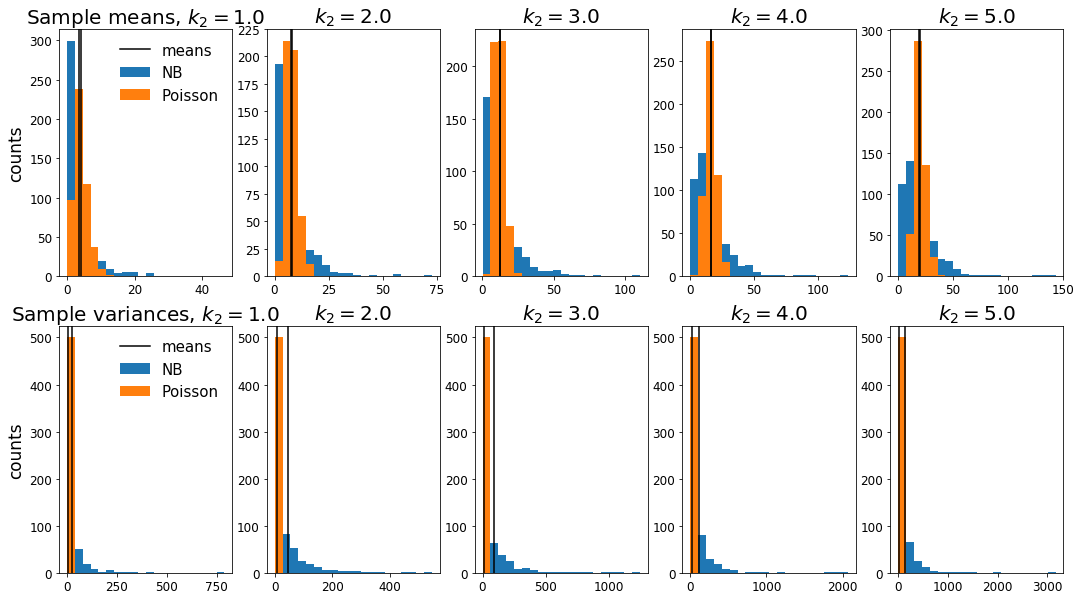

In [5]:
k2s = np.linspace(1, 5, 5)
nb_means = np.zeros(k2s.size)
k1s = np.zeros_like(k2s)
poi_means = np.zeros(k2s.size)
nb_vars = np.zeros(k2s.size)
poi_vars = np.zeros(k2s.size)

plt.figure(figsize=(18, 10))

for ii, k2 in enumerate(k2s): 
    k1 = (k2 * theta2 * k3 * theta3) / theta1
    k1s[ii] = k1
    
    # from Gamma prior for Poisson 
    params_poi = rng.gamma(shape=k1, scale=theta1, size=int(ntrain / 2))

    # from two Gamma priors for indirect Poisson-Gamma Sampling.
    params_nb = np.vstack((rng.gamma(shape=k2, scale=theta2, size=int(ntrain / 2)), 
                           rng.gamma(shape=k3, scale=theta3, size=int(ntrain / 2)))).T
        
    data_poi = model_poisson.gen(params_poi)
    data_nb = model_nb.gen(params_nb)
    
    plt.subplot(2, 5, ii + 1)
    n_bins = 20
    n, bins, patches = plt.hist(data_nb.mean(axis=1), color='C0', label='NB', bins=n_bins)
    plt.hist(data_poi.mean(axis=1), color='C1', label='Poisson', bins=bins)
    plt.axvline(x=data_nb.mean(axis=1).mean(), color='k', label='means')
    plt.axvline(x=data_poi.mean(axis=1).mean(), color='k')
    if ii==0: 
        plt.title(r'Sample means, $k_2={}$'.format(k2))
        plt.ylabel('counts')
        plt.legend()
    else: 
        plt.title(r'$k_2={}$'.format(k2))    
    
    plt.subplot(2, 5, ii + 6)        
    n, bins, patches = plt.hist(data_nb.var(axis=1), color='C0', label='NB', bins=n_bins)
    plt.hist(data_poi.var(axis=1), color='C1', label='Poisson', bins=bins)
    plt.axvline(x=data_nb.var(axis=1).mean(), color='k', label='means')
    plt.axvline(x=data_poi.var(axis=1).mean(), color='k')
        
        
    if ii == 0: 
        plt.title(r'Sample variances, $k_2={}$'.format(k2))
        plt.ylabel('counts')
        plt.legend()
    else: 
        plt.title(r'$k_2={}$'.format(k2))
        
    # expected means and variances 
    nb_means[ii] = data_nb.mean(axis=1).mean()
    nb_vars[ii] = data_nb.var(axis=1).mean()
    poi_means[ii] = data_poi.mean(axis=1).mean()
    poi_vars[ii] = data_poi.var(axis=1).mean()

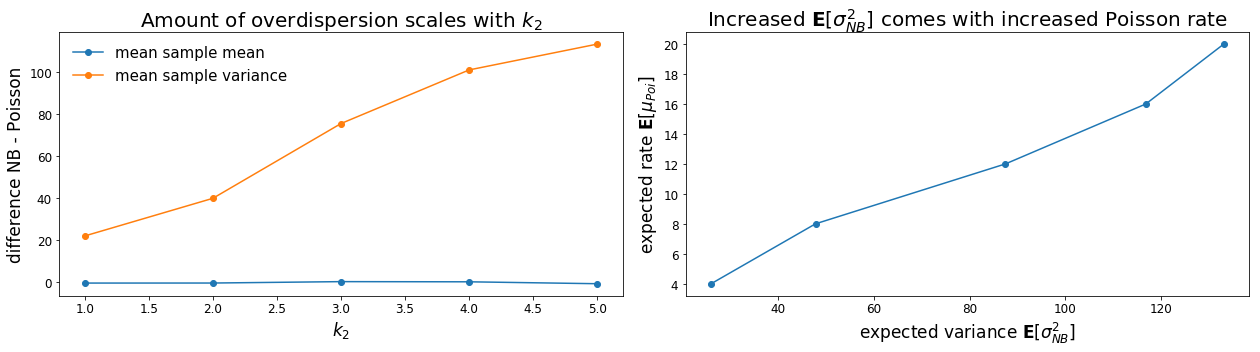

In [6]:
expvar = k2s * k3 * theta2 * theta3 * (1 + k3 * theta3 + theta3)

plt.subplot(121)
plt.plot(k2s, nb_means - poi_means, '-o', label='mean sample mean')
plt.plot(k2s, nb_vars - poi_vars, '-o', label='mean sample variance')

plt.xlabel(r'$k_2$')
plt.ylabel('difference NB - Poisson')
plt.legend()
plt.title(r'Amount of overdispersion scales with $k_2$')


plt.subplot(122)
plt.title('Increased $\mathbf{E}[\sigma_{NB}^2]$ comes with increased Poisson rate')
plt.plot(nb_vars, k1s * theta1, '-o', label=r'mean of Gamma prior: $k_1 \theta_1$')
plt.ylabel(r'expected rate $\mathbf{E}[\mu_{Poi}]$')
plt.xlabel(r'expected variance $\mathbf{E}[\sigma_{NB}^2]$')

plt.tight_layout();
plt.savefig('../figures/effect_of_k2_on_stats.png', dpi=300)

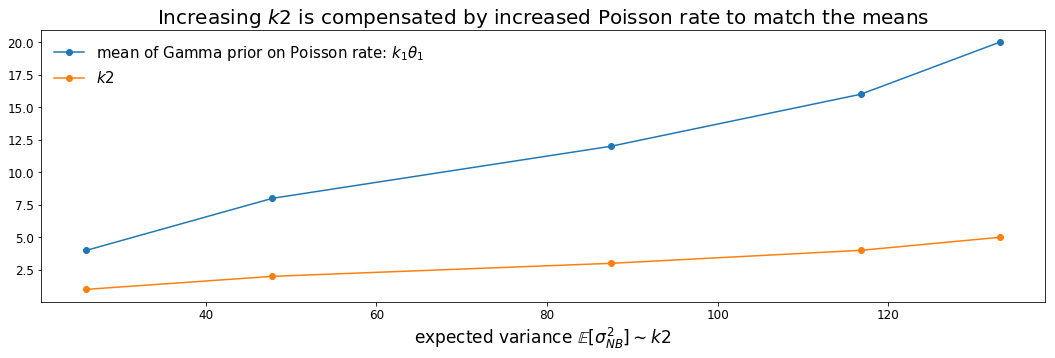

In [7]:
expvar = k2s * k3 * theta2 * theta3 * (1 + k3 * theta3 + theta3)
plt.plot(nb_vars, k1s * theta1, '-o', label=r'mean of Gamma prior on Poisson rate: $k_1 \theta_1$')
plt.plot(nb_vars, k2s, '-o', label=r'$k2$')
plt.legend()
plt.title('Increasing $k2$ is compensated by increased Poisson rate to match the means')
plt.xlabel(r'expected variance $\mathbb{E}[\sigma_{NB}^2] \sim k2$');

## Network performance visualization 

In [18]:
def plot_nn_visulatization(d, ax, xmax, ymax):
    model = d['model_models']
    norm = d['training_norm']
    x, y = np.meshgrid(np.linspace(0, xmax, 100), np.linspace(0, ymax, 100))

    ppoi_mat = np.zeros((x.shape[0], y.shape[0]))

    for i in range(x.shape[0]): 
        for j in range(x.shape[0]): 
            stats_o, norm = normalize(np.array([x[i, j], y[i, j]]), norm)
            posterior_probs = model(Variable(torch.Tensor(stats_o.reshape(1, -1)))).data.numpy().squeeze()
            # in this vector, index 0 is Poi, index 1 is NB
            ppoi_mat[i, j] = posterior_probs[0]
    
    testSX = d['sx_test']
    ppoi_ana = d['ppoi_exact']
    n_samples = d['n_samples']
    
    cnorm = mpl.colors.Normalize(vmin=ppoi_mat.min(), vmax=ppoi_mat.max())
    cmap = plt.cm.viridis

    ax.scatter(x=testSX[:, 0], y=testSX[:, 1], c=ppoi_ana, cmap=cmap, norm=cnorm, edgecolors='r', linewidths=0.5)

    cax = ax.imshow(ppoi_mat, origin='lower', aspect='auto', 
                    norm=cnorm, cmap=cmap, extent=[x.min(), x.max(), y.min(), y.max()])
    ax.set_xlabel('Sample mean')
    ax.set_ylabel('Sample variance')
    plt.colorbar(cax, ax=ax, label=r'$P(M_{Poisson} | x)$', pad=0.02)
    ax.legend(['Exact posterior probabilities'], frameon=True)

### Load results

In [19]:
folder = '../data/'
fn_difficult = '201803220946_toy_example_results_N100000M10_k21.0.p'
fn_easy = '201803211432_toy_example_results_N100000M10_k220.0.p'

with open(os.path.join(folder, fn_difficult), 'rb') as f: 
    d_didd = pickle.load(f)
    
with open(os.path.join(folder, fn_easy), 'rb') as f: 
    d_easy = pickle.load(f)


In [20]:
d_didd.keys()

dict_keys(['model_post', 'param_post'])

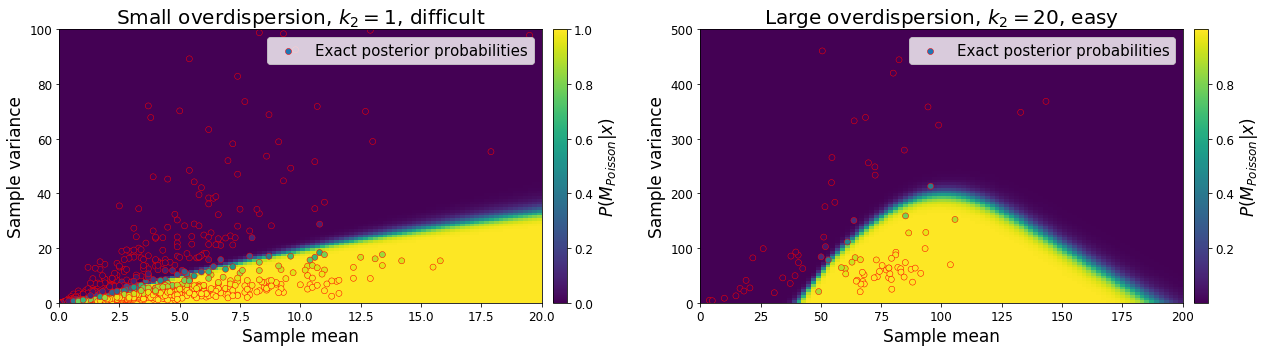

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
plot_nn_visulatization(d_didd['model_post'], ax1, xmax=20, ymax=100)
ax1.set_title('Small overdispersion, $k_2=1$, difficult')

plot_nn_visulatization(d_easy['model_post'], ax2, xmax=200, ymax=500)
ax2.set_title('Large overdispersion, $k_2=20$, easy')
fig.tight_layout()

In [22]:
n_samples = d_didd['model_post']['n_samples']
time_stamp = time.strftime('%Y%m%d%H%M_')
fn = time_stamp + '_network_visualization_M{}N{}'.format(sample_size, n_samples) + '.png'
folder = '../figures/'
fig.savefig(os.path.join(folder, fn), dpi=300)

In [23]:
rng.gamma(shape=k1, scale=theta1)

16.56273940451928

In [24]:
model_poisson = PoissonModel(sample_size=1000, seed=seed)
model_nb = NegativeBinomialModel(sample_size=1000, seed=seed)

In [25]:
d1 = model_poisson.gen([rng.gamma(shape=k1, scale=theta1)])[0]
d2 = model_nb.gen([[rng.gamma(shape=k2, scale=theta2), rng.gamma(shape=k2, scale=theta2)]])[0]
d1.mean(), d2.mean()

(24.111000000000001, 14.802)

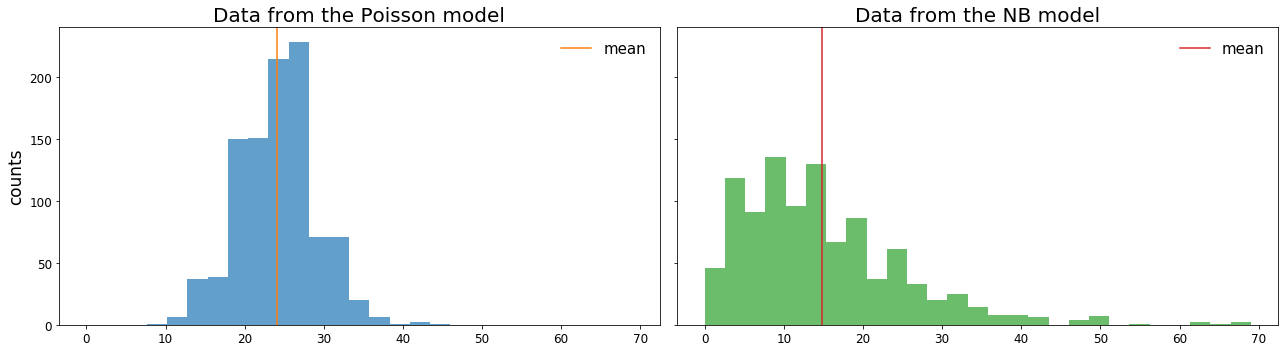

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5), sharey=True, sharex=True)

alp = 0.7
n, bins, p = ax[1].hist(d2, bins='auto', color='C2', alpha=alp)
ax[1].set_title('Data from the NB model')
ax[1].axvline(x=d2.mean(), color='C3', label='mean')
ax[1].legend();

ax[0].hist(d1, bins=bins, color='C0', alpha=alp)
ax[0].set_title('Data from the Poisson model')
ax[0].set_ylabel('counts')
ax[0].axvline(x=d1.mean(), color='C1', label='mean')
ax[0].legend()
fig.tight_layout();

In [33]:
fig.savefig('../figures/poisson_nb_sample_example.png', dpi=300)

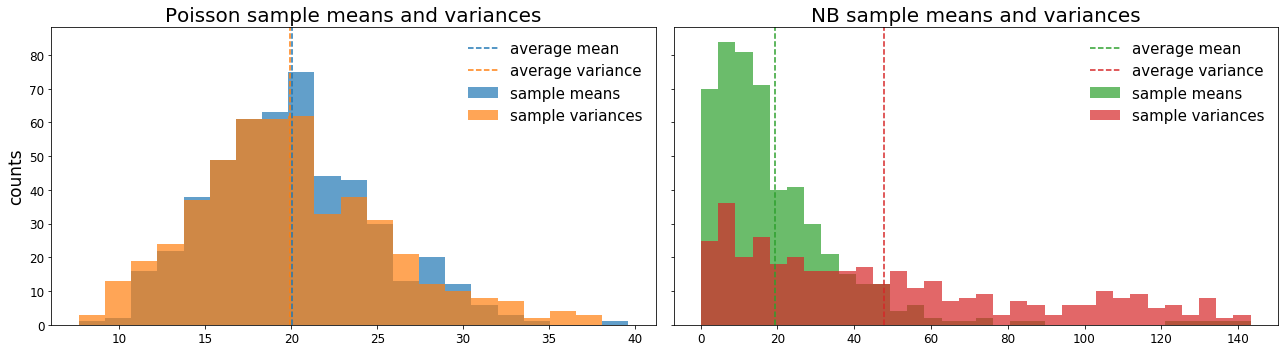

In [34]:
fig2, ax = plt.subplots(1, 2, figsize=(18, 5), sharey=True, sharex=False)

n, bins, p = ax[0].hist(data_poi.mean(axis=1), bins='auto', label='sample means', alpha=alp)
ax[0].hist(data_poi.var(axis=1), bins=bins, label='sample variances', alpha=alp)
ax[0].set_title('Poisson sample means and variances')
ax[0].set_ylabel('counts')
ax[0].axvline(x=data_poi.mean(), linestyle='--', color='C0', label='average mean')
ax[0].axvline(x=data_poi.var(axis=1).mean(), linestyle='--', color='C1', label='average variance')
ax[0].legend()

n, bins, p = ax[1].hist(data_nb.mean(axis=1), bins='auto', color='C2', label='sample means', alpha=alp)
n1, bins, p = ax[1].hist(data_nb.var(axis=1), bins=bins, color='C3', label='sample variances', alpha=alp)
ax[1].set_title('NB sample means and variances')
ax[1].axvline(data_nb.mean(), linestyle='--', color='C2', label='average mean')
vs = data_nb.var(axis=1)
vs.sort()
ax[1].axvline(vs[:int(n1.sum())].mean(), linestyle='--', color='C3', label='average variance')
ax[1].legend()


fig2.tight_layout();

In [35]:
fig2.savefig('../figures/poisson_nb_stats_example.png', dpi=300)